In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.spatial.transform as stf
import re
from scipy.interpolate import make_interp_spline
from scipy.ndimage.filters import gaussian_filter1d

In [7]:
def scoreMultipleTrajectories(gt_path, *args, scale = False, plot = True, s = 0, e = 1000, time_offset = 2.1):
    df_gt = pd.read_csv(gt_path)
    gt_data = df_gt.iloc[:,1:].to_numpy()
    df_estimated = [pd.read_csv(traj_path, index_col = False).iloc[s:e,:] for traj_path in args]
    
    interpolated_gt_time = make_interp_spline(gt_data[:,0], np.c_[gt_data[:,1], gt_data[:,2], gt_data[:,3]])
    
    # Remove Nan values
    df_estimated = [df2.iloc[~np.isnan(df2['x'].to_numpy()),:] for df2 in df_estimated]
    positions = [df[['x_pos','y_pos','z_pos']].to_numpy() for df in df_estimated]
    rotations = [df[['x','y','z','w']].to_numpy() for df in df_estimated]
    T_lidar_leica = np.array([0.14, 0.20, 0.26])
    trajectories = []
    names = []
    for i, pos in enumerate(positions):
        trajectories.append(pos + stf.Rotation.from_quat(rotations[i]).apply(T_lidar_leica))
        names.append(args[i])
        
    if plot:
        plt.title("Trajectories")
        plt.figure(figsize=(20, 20))
        plt.plot(-gt_data[s:e,1], -gt_data[s:e,2],linewidth=4)
        plt.ylim([-5,5])
        plt.xlim([-4,6])
        for traj in trajectories:
            plt.plot(traj[:,0],traj[:,1],'--',linewidth=4)
        #plt.legend(["ground truth", *names])
        plt.legend(["ground truth", "No Segmentation", "Segmented"])
    
    gt_timestamps = df_gt['Timestamps'].to_numpy()
    traj_timestamps = [df['Timestamp'].to_numpy() for df in df_estimated]
    # valid_timestamps = [np.intersect1d(ts, gt_timestamps) for ts in traj_timestamps]
    synchronized_traj = []
    
    for idx, timestamps in enumerate(traj_timestamps):
        #reduced_gt = gt_data[np.isin(gt_timestamps, timestamps),:]
        #reduced_traj = trajectories[idx][np.isin(traj_timestamps[idx], timestamps),:]
        data = interpolated_gt_time(timestamps + time_offset)
        synchronized_traj.append((data, trajectories[idx]))
    if plot:
        plt.title("Selected timstamps")
        plt.figure(figsize=(20, 20))
        plotted_gt = False
        for gt, traj in synchronized_traj:
            if not plotted_gt:
                plt.scatter(-gt[:,0], -gt[:,1])
                plotted_gt = True
            plt.scatter(traj[:,0], traj[:,1])
        plt.ylim([-5,5])
        plt.xlim([-4,6])
            
        plt.legend(['groundtruth', *args])
        if scale:
            plt.ylim([-20,20])
            plt.xlim([-5,35])
        plt.show()
    global errors
        
    errors = []
    for gt, traj in synchronized_traj:
        error = -gt - traj
        errorXY = error[:,0:2]
        errors.append((error, errorXY))
    
    plt.figure(figsize=(20, 20))
    plt.title("Error (RMS)")
    for _, errorXY in errors:
        rms = np.sqrt(np.mean(errorXY**2, axis = 1))
        #plt.plot(rms)
        plt.plot(rms[::3])

    plt.legend([*args])
    for idx, (_,errorXY) in enumerate(errors):
        print(f"RMSE: {np.sqrt(np.mean(errorXY**2)):.4f} - {args[idx]}")
    return np.sqrt(np.mean(errors[0][1]**2)) - np.sqrt(np.mean(errors[1][1]**2))

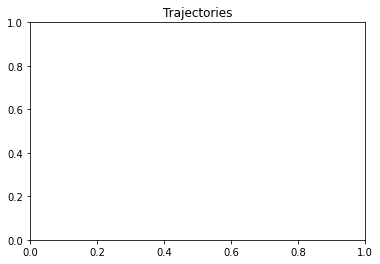

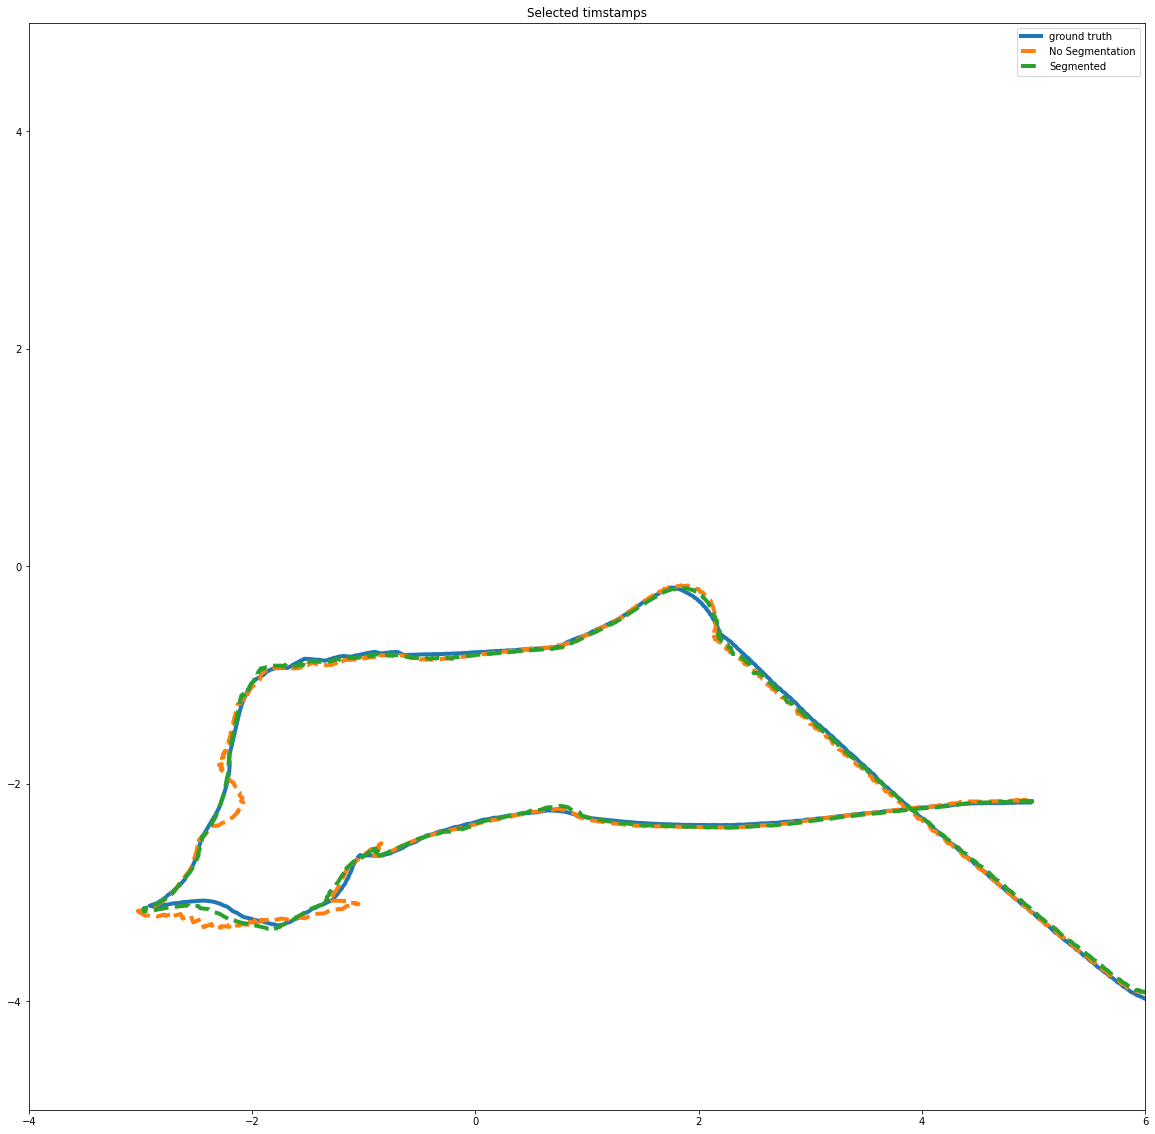

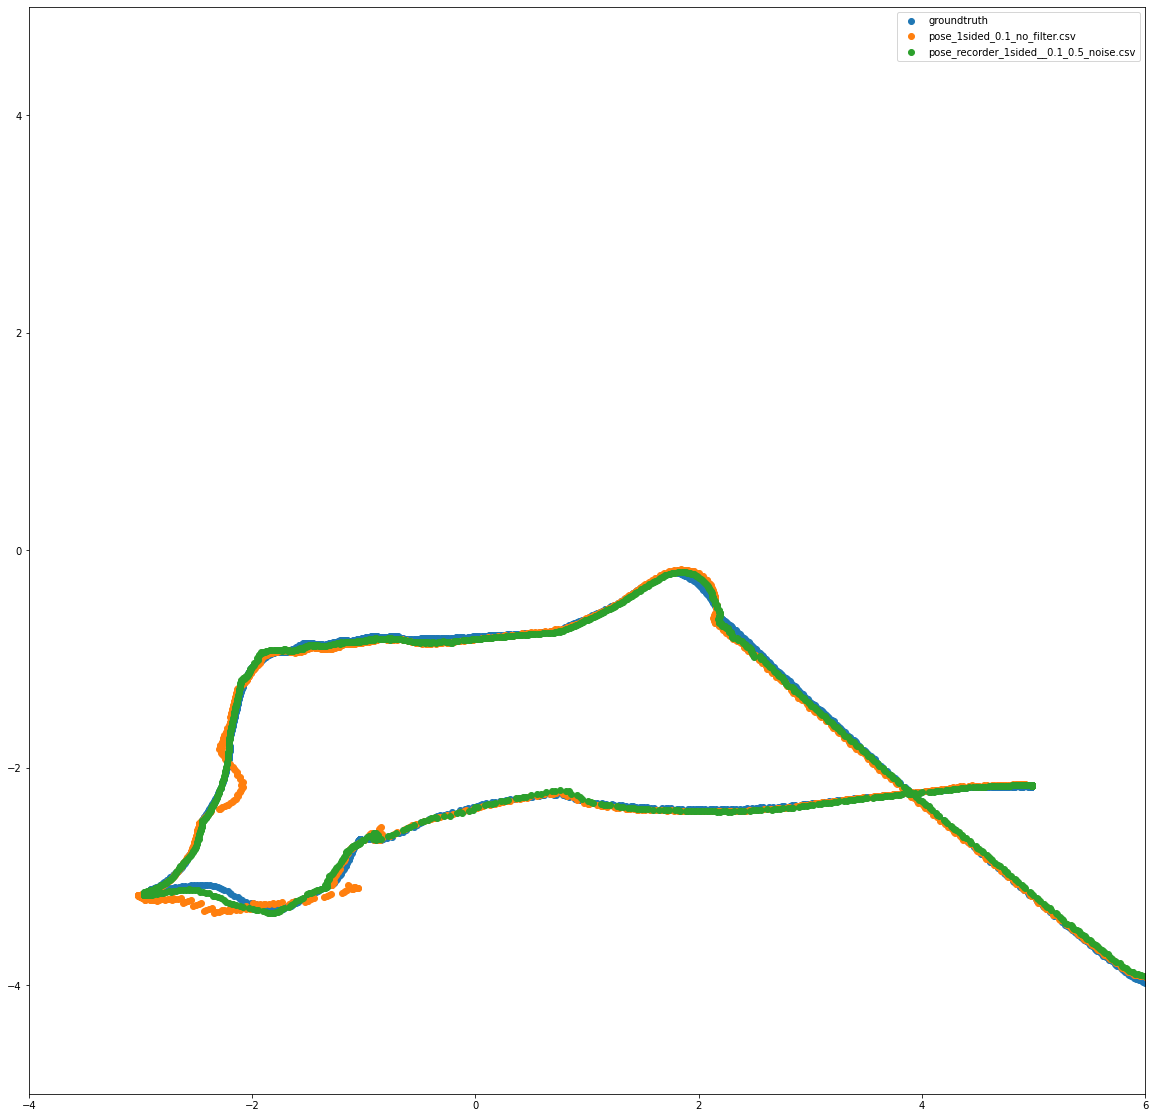

RMSE: 0.0518 - pose_1sided_0.1_no_filter.csv
RMSE: 0.0373 - pose_recorder_1sided__0.1_0.5_noise.csv


0.01443660926215646

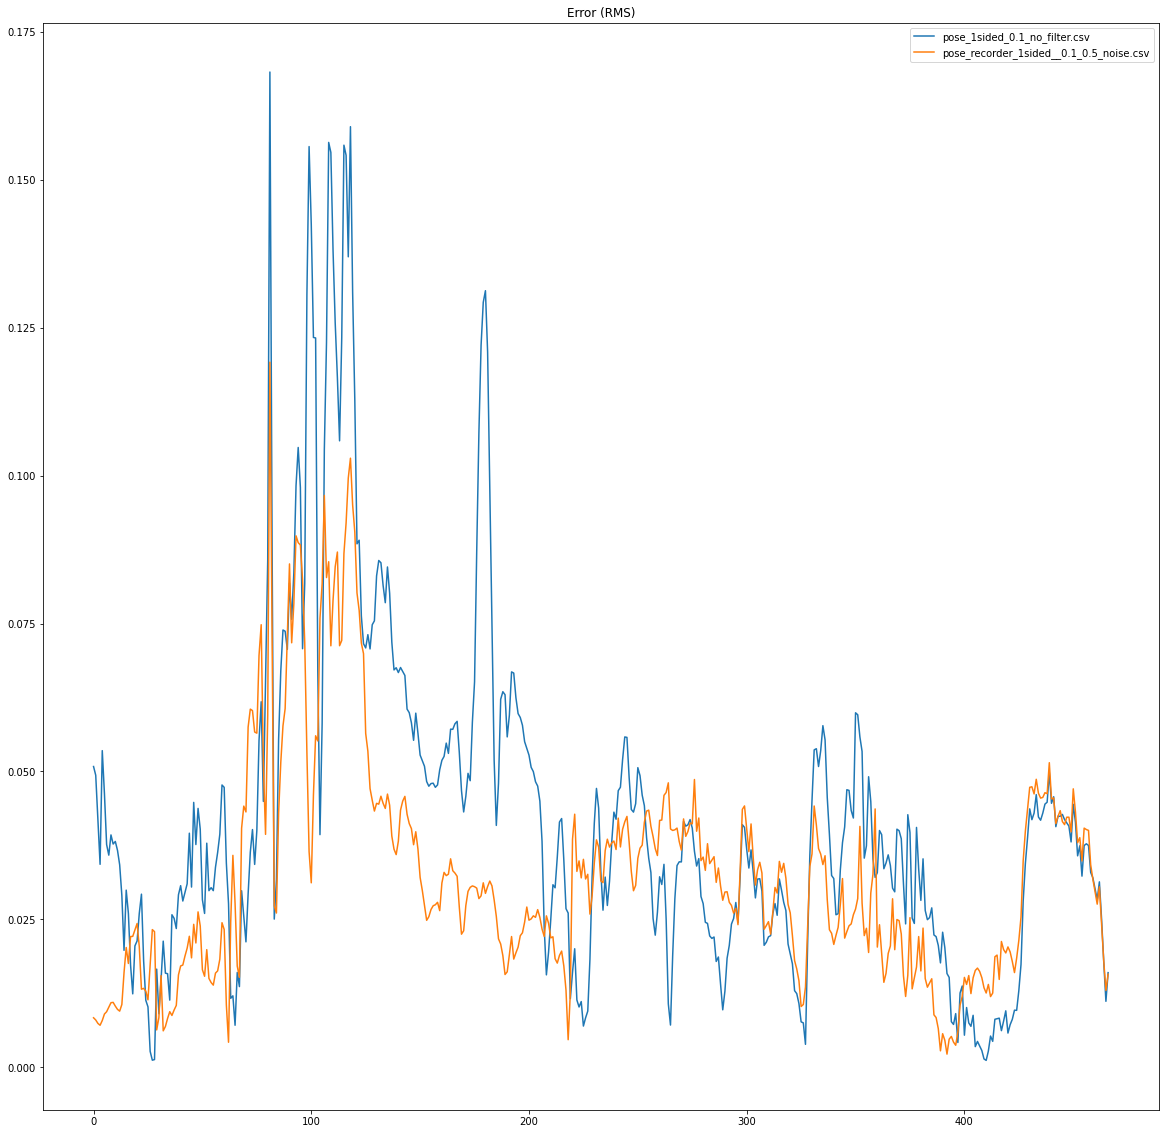

In [9]:
scoreMultipleTrajectories("/media/rene/Games/ROSBAG/gt_lidar_pos.csv", "pose_1sided_0.1_no_filter.csv", "pose_recorder_1sided__0.1_0.5_noise.csv", scale = False, s = 100, e =1500, time_offset = 1.7 + 1/30, plot= True)

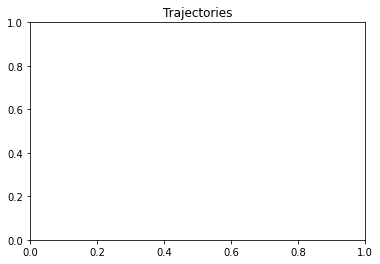

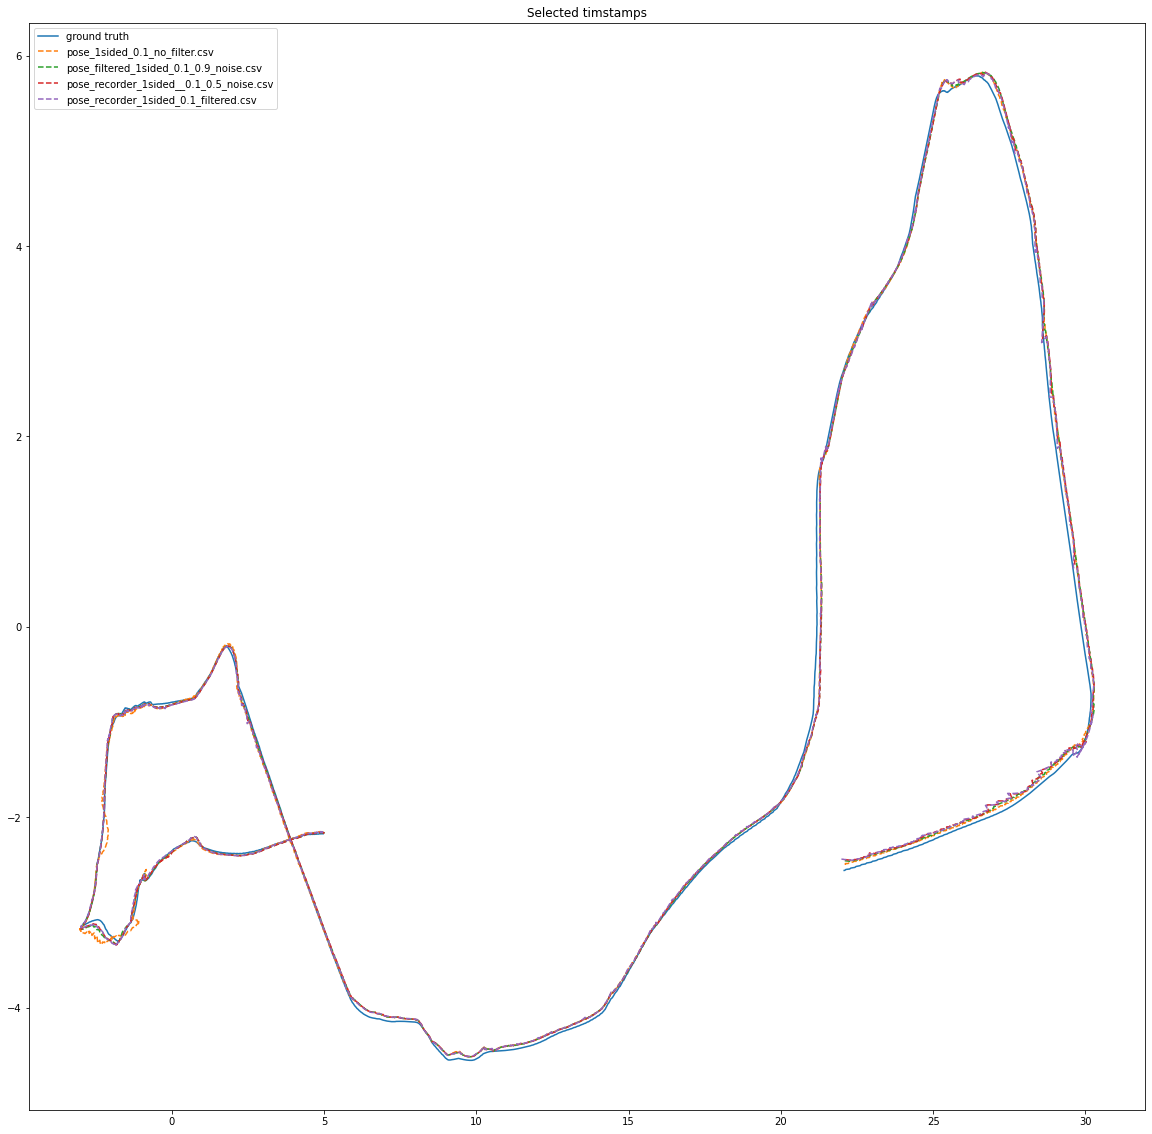

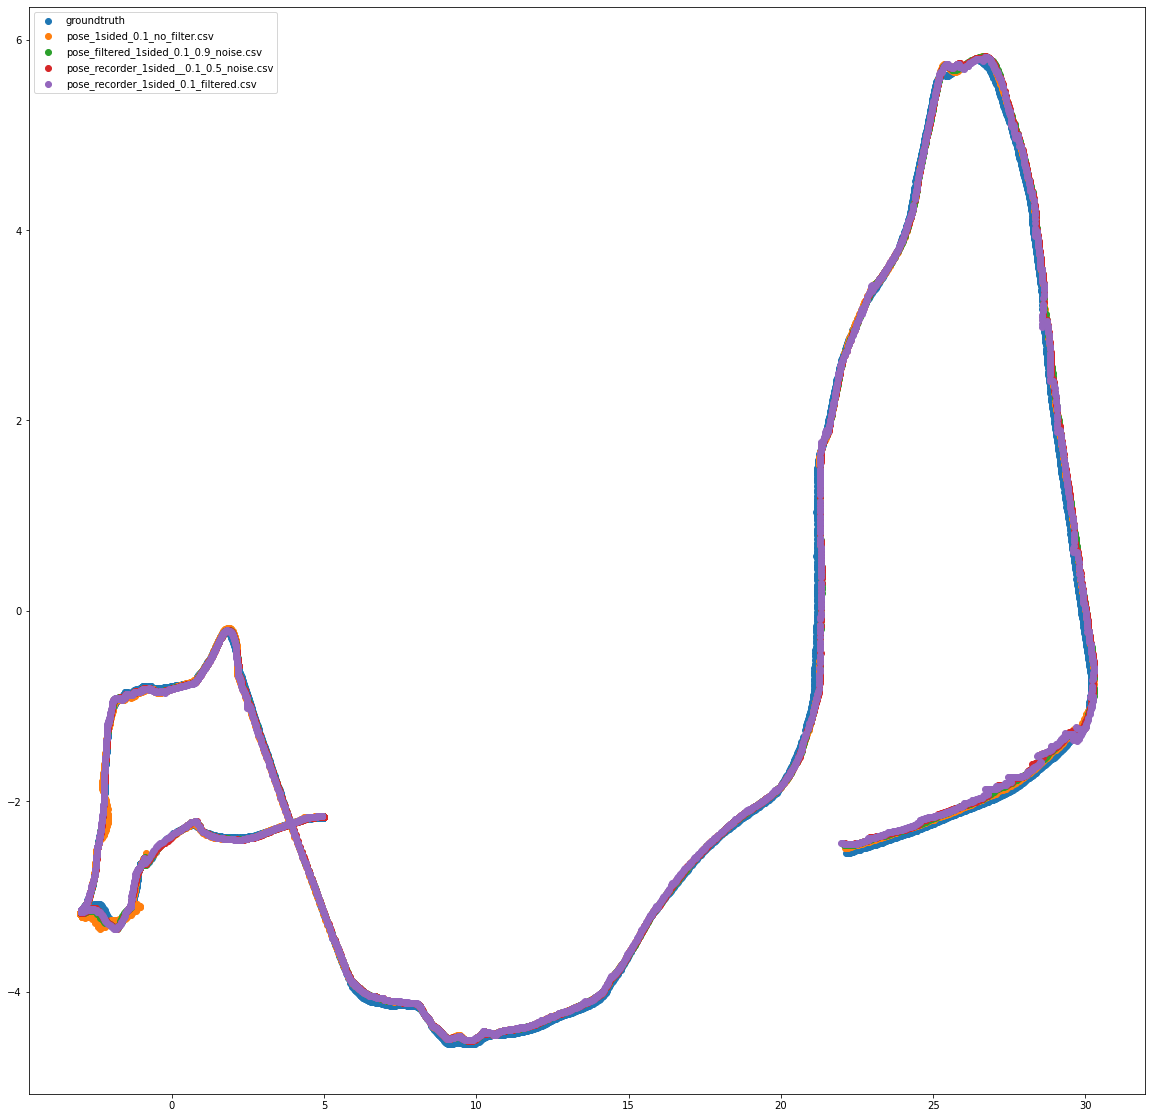

RMSE: 0.1079 - pose_1sided_0.1_no_filter.csv
RMSE: 0.1072 - pose_filtered_1sided_0.1_0.9_noise.csv
RMSE: 0.1086 - pose_recorder_1sided__0.1_0.5_noise.csv
RMSE: 0.1113 - pose_recorder_1sided_0.1_filtered.csv


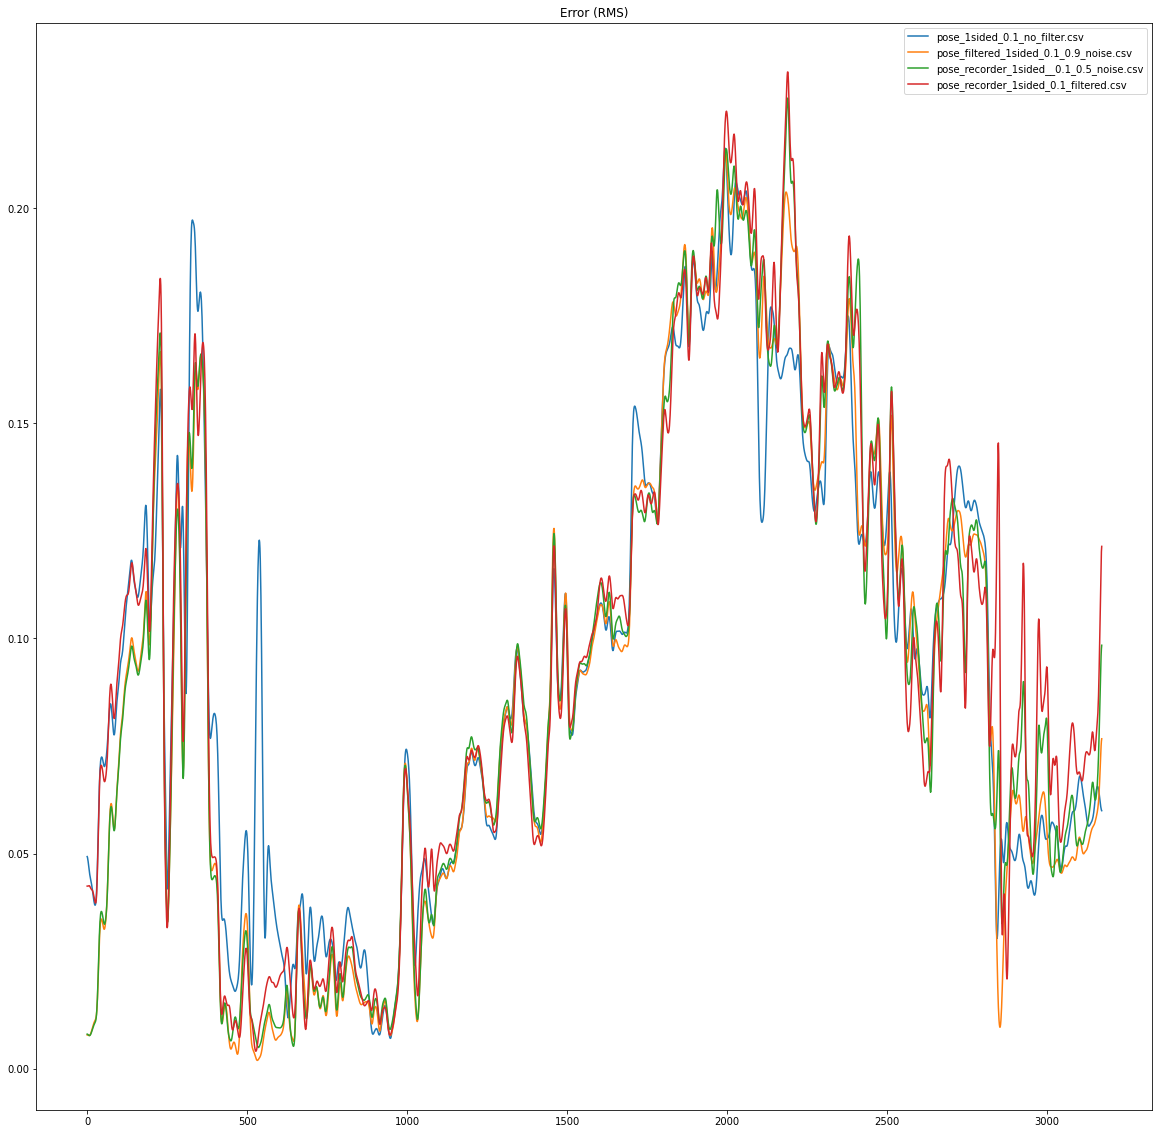

In [7]:
scoreMultipleTrajectories("/media/rene/Games/ROSBAG/gt_lidar_pos.csv", "pose_1sided_0.1_no_filter.csv", "pose_filtered_1sided_0.1_0.9_noise.csv", "pose_recorder_1sided__0.1_0.5_noise.csv", "pose_recorder_1sided_0.1_filtered.csv", scale = False, s = 100, e =10000, time_offset = 1.5)

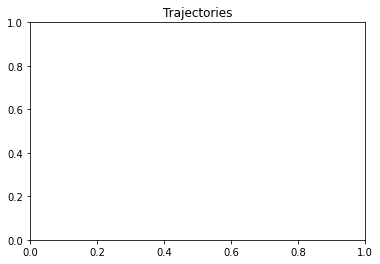

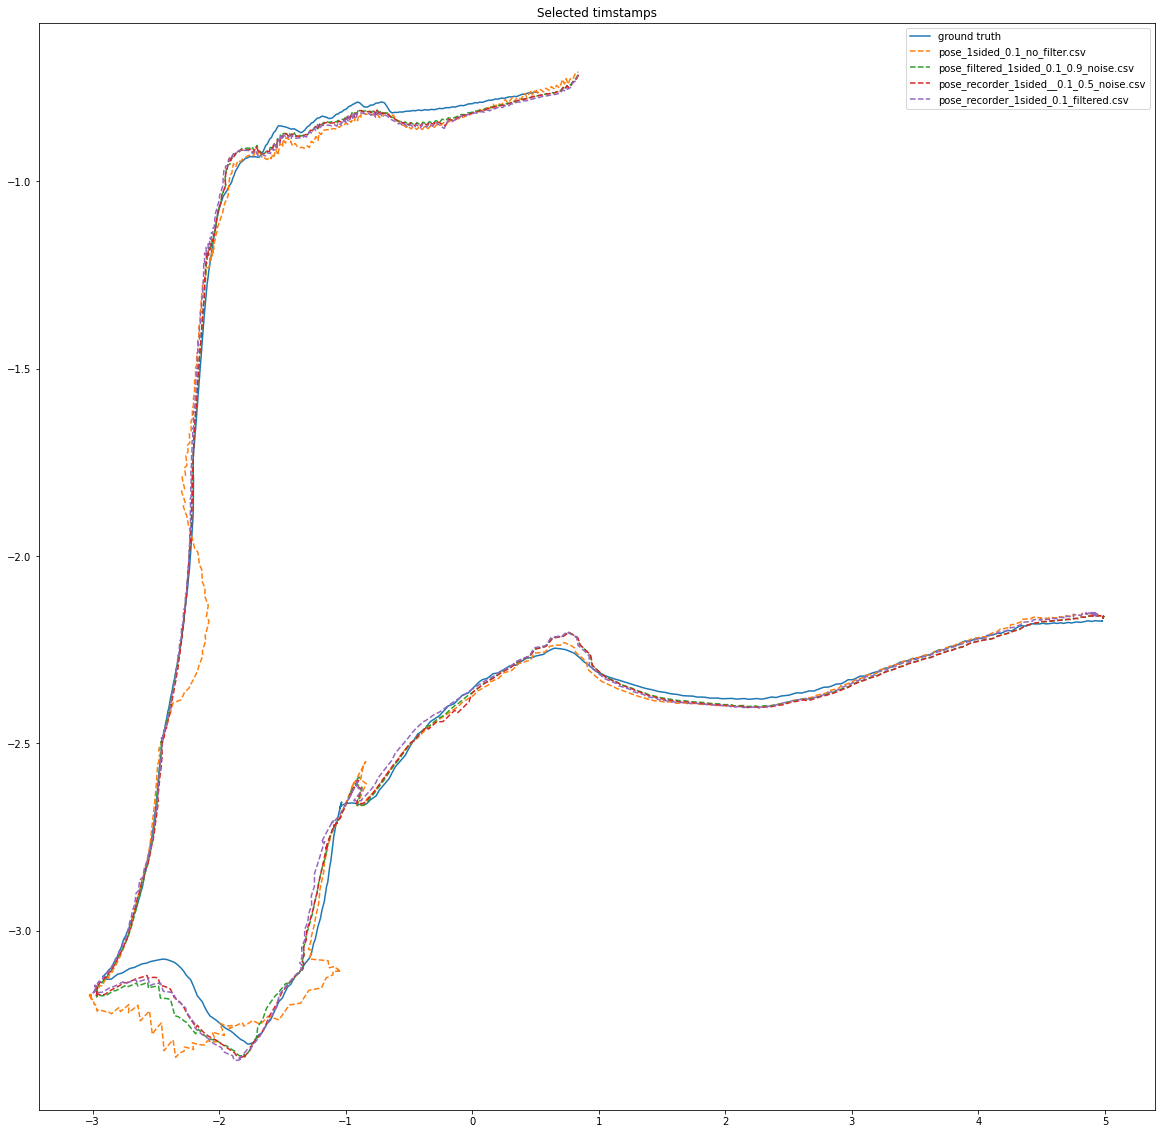

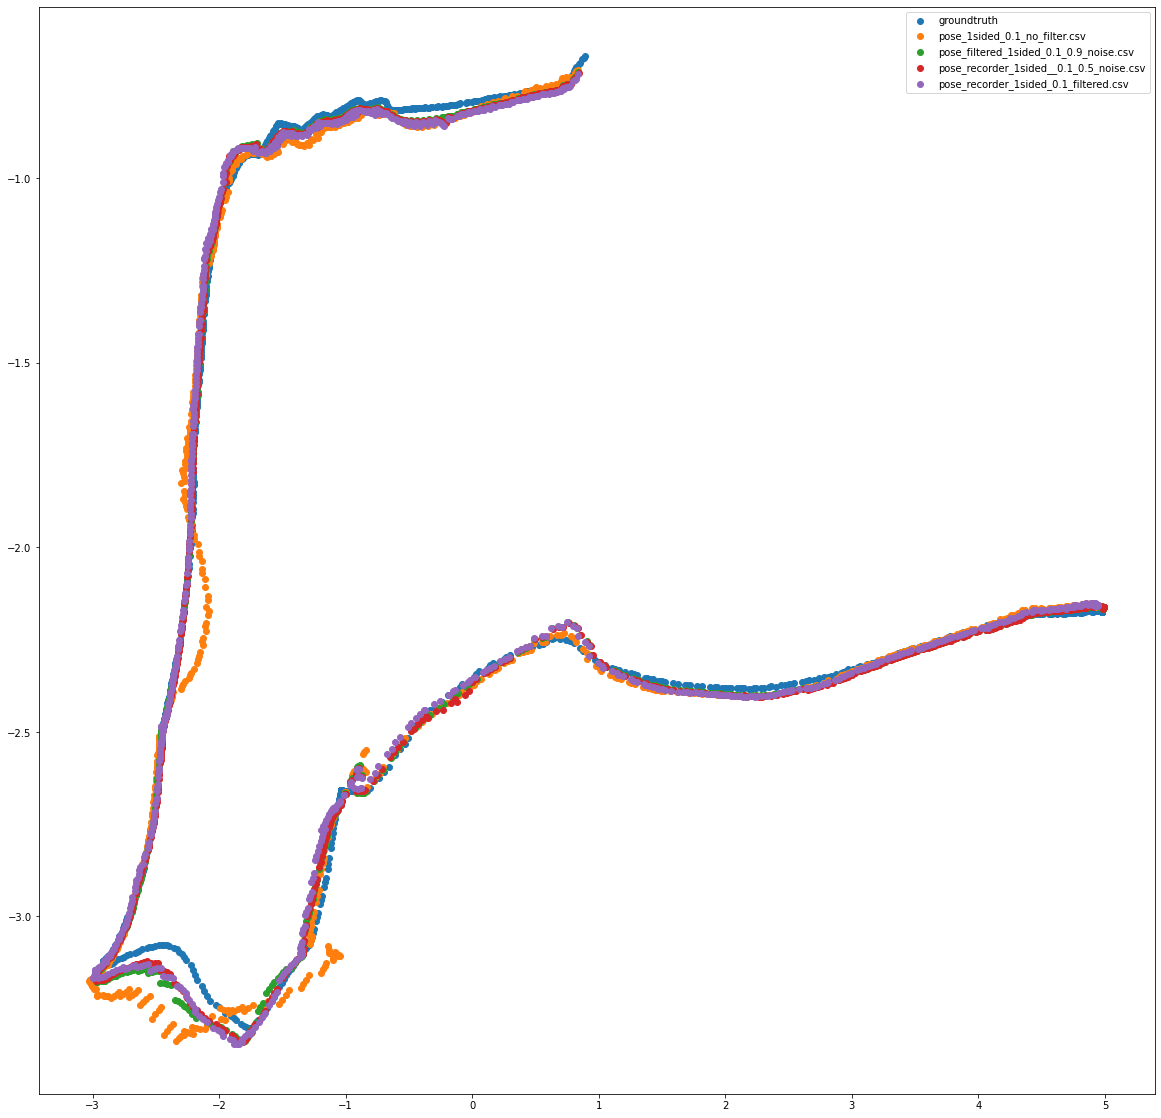

RMSE: 0.0599 - pose_1sided_0.1_no_filter.csv
RMSE: 0.0430 - pose_filtered_1sided_0.1_0.9_noise.csv
RMSE: 0.0420 - pose_recorder_1sided__0.1_0.5_noise.csv
RMSE: 0.0450 - pose_recorder_1sided_0.1_filtered.csv


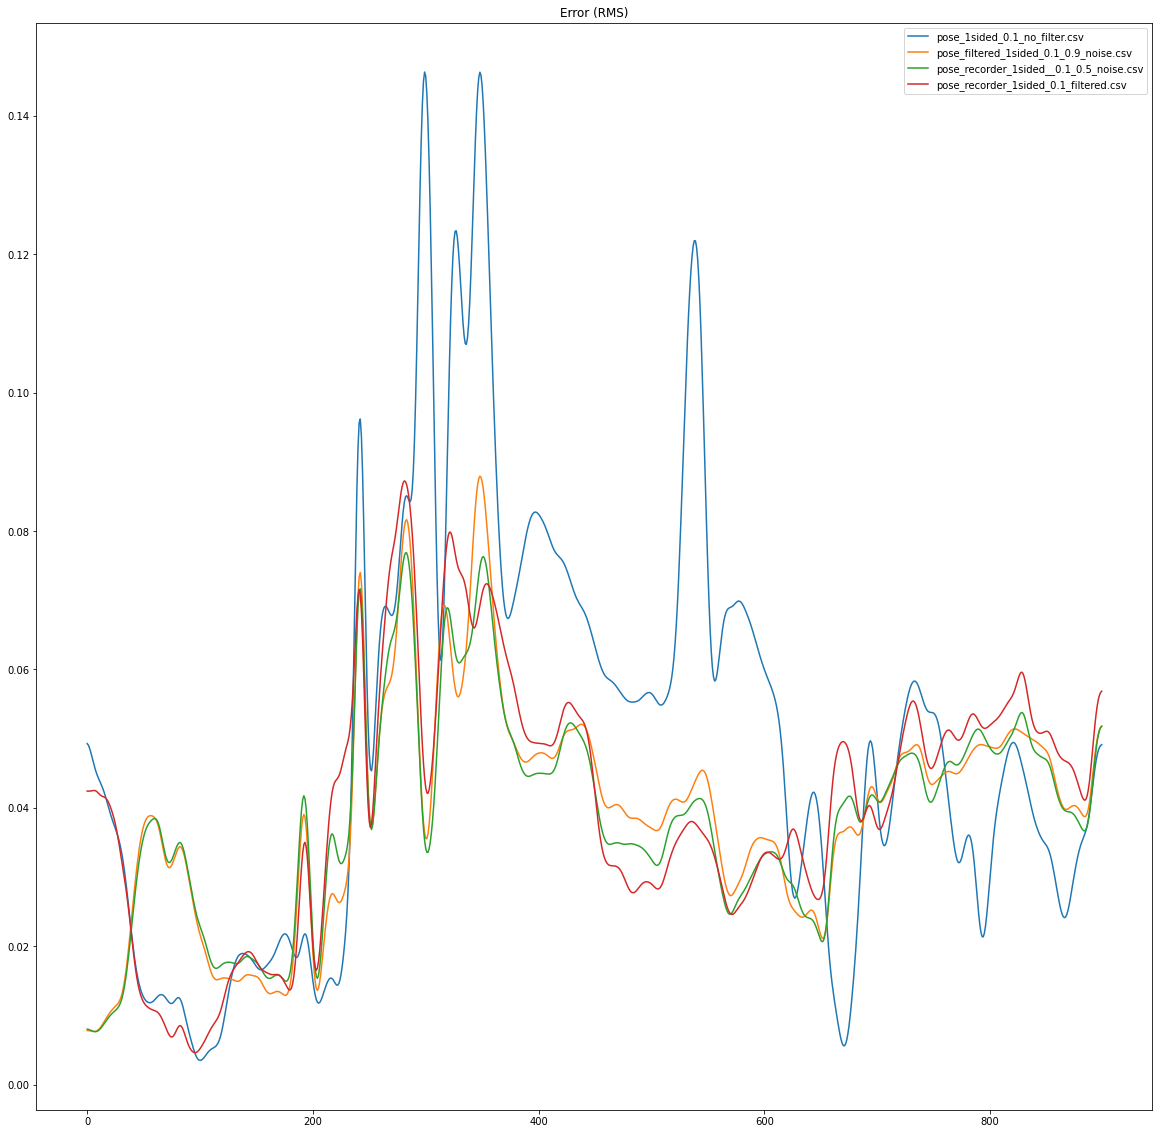

In [8]:
scoreMultipleTrajectories("/media/rene/Games/ROSBAG/gt_lidar_pos.csv", "pose_1sided_0.1_no_filter.csv", "pose_filtered_1sided_0.1_0.9_noise.csv", "pose_recorder_1sided__0.1_0.5_noise.csv", "pose_recorder_1sided_0.1_filtered.csv", scale = False, s = 100, e =1000, time_offset = 1.8)